In [45]:
HTML('''<script> code_shown=true;function code_toggle() {if (code_shown){$('div.input').hide();$('#toggleButton').val('Show Code')} else {$('div.input').show();$('#toggleButton').val('Hide Code')}code_shown = !code_shown}$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" id="toggleButton"></form>''')

# Trending YouTube Videos

In [139]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import json
import warnings
from IPython.lib.display import YouTubeVideo
import re
from IPython.core.display import display, HTML
pd.set_option('display.max_colwidth', -1) #for all data of df to be seen
import matplotlib.pyplot as plt
import math



YouTube is an American video-sharing website headquartered in San Bruno, California. The service was created by three former PayPal employees—Chad Hurley, Steve Chen, and Jawed Karim—in February 2005. Google bought the site in November 2006 for US$1.65 billion; YouTube now operates as one of Google's subsidiaries.
YouTube allows users to upload, view, rate, share, add to favourites, report, comment on videos, and subscribe to other users. It offers a wide variety of user-generated and corporate media videos. Available content includes video clips, TV show clips, music videos, short and documentary films, audio recordings, movie trailers, live streams, and other content such as video blogging, short original videos, and educational videos. Most of the content on YouTube is uploaded by individuals, but media corporations including CBS, the BBC, Vevo, and Hulu offer some of their material via YouTube as part of the YouTube partnership program. Unregistered users can only watch videos on the site, while registered users are permitted to upload an unlimited number of videos and add comments to videos. 



## Trending Videos



Although the most viewed videos were initially viral videos the most viewed videos were increasingly related to music videos. In fact, since recently every video that has reached the top of the "most viewed YouTube videos" list has been a music video. Although the most viewed videos are no longer listed on the site, reaching the top of the list is still considered a tremendous feat.
YouTube maintains a list of the top trending videos on the platform. According to Variety magazine, “To determine the year’s top-trending videos, YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes). Note that they’re not the most-viewed videos overall for the calendar year”. Top performers on the YouTube trending list are music videos (such as the famously virile “Gangam Style”), celebrity and/or reality TV performances, and the random dude-with-a-camera viral videos that YouTube is well-known for.



## The Datasets



2 datasets will be used for the purpose of this project, 2 sets of five files csv and JSON

One of the datasets used is a daily record of the top trending YouTube videos. The dataset includes several months (and counting) of data on daily trending YouTube videos. Data is included for the US, GB, DE, CA, and FR regions (USA, Great Britain, Germany, Canada, and France, respectively), with up to 200 listed trending videos per day.
Each region’s data is in a separate file. Data includes the video title, channel title, publish time, tags, views, likes and dislikes, description, and comment count.

The second data set (JSON files) includes a category_id field and varies between regions. One such file is included for each of the five regions in the dataset.
.
The headers in the video files are:

•	video_id (Common id field to both comment and video csv files)

•	title

•	channel_title

•	category_id (Can be looked up using the included JSON files, but varies per region so use the appropriate JSON file for the CSV file's country)

•	tags (Separated by | character, [none] is displayed if there are no tags)

•	views

•	likes

•	dislikes

•	thumbnail_link

•	date (Formatted like so: [day].[month])


The headers in the comments file are:

•	video_id (Common id field to both comment and video csv files)

•	comment_text

•	likes

•	replies




## Data manipulation prosses 

In [4]:
# Upload Data
US_videos = pd.read_csv('USvideos.csv.zip')
US_videos_categories = pd.read_json('US_category_id.json')
CA_videos = pd.read_csv('CAvideos.csv.zip')
CA_videos_categories = pd.read_json('CA_category_id.json')
GB_videos = pd.read_csv('GBvideos.csv.zip')
GB_videos_categories = pd.read_json('GB_category_id.json')
FR_videos = pd.read_csv('FRvideos.csv.zip')
FR_videos_categories = pd.read_json('FR_category_id.json')
DE_videos = pd.read_csv('DEvideos.csv.zip')
DE_videos_categories = pd.read_json('DE_category_id.json')

In [5]:
#Create the video df
#df_videos = pd.concat([US_videos, CA_videos, GB_videos, FR_videos, DE_videos])
videos_list = [US_videos, CA_videos, GB_videos, FR_videos, DE_videos]
videos_all = pd.concat(videos_list, keys=['US', 'CA', 'GB', 'FR', 'DE'], names=['Country', 'Row ID'])

In [6]:
#Create the video categories df¶
#df_videos_categ = pd.concat([US_videos_categories, CA_videos_categories, GB_videos_categories,  FR_videos_categories, DE_videos_categories])
US_videos_categories['country'] = 'US'
GB_videos_categories['country'] = 'GB'
CA_videos_categories['country'] = 'CA'
FR_videos_categories['country'] = 'FR'
DE_videos_categories['country'] = 'DE'

df_videos_categ = pd.concat([US_videos_categories, 
                             CA_videos_categories, 
                             GB_videos_categories,  
                             FR_videos_categories, 
                             DE_videos_categories], keys=['US', 'CA', 'GB', 'FR', 'DE'])

#### Merging the data-sets
To create the full dataset the region’s data where uploaded and merged in one data frame. The files with the category information were uploaded and merged into another data set. The category id and category name where stored in a data frame the elements of witch were dictionaries. The column instead of pandas series where iteritems. As a result there were problems to treat the data since there was not a typical pandas series.
Below you can have a look of the category table.

In [7]:
df_videos_categ.head(1)

,,etag,items,kind,country
US,0,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJvJAAShlR6hM""","{'kind': 'youtube#videoCategory', 'etag': '""m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKmPBggty2mZQ""', 'id': '1', 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'title': 'Film & Animation', 'assignable': True}}",youtube#videoCategoryListResponse,US


#### Formatting
The dates columns were formatted to datetime. Also, the hour, day and month info was extracted. Also the views, comments, likes columns were changes to integers.

#### Data Cleaning
In order to make the nessesary change in format some rows had to be deleted since there was wrong information stored as date in some cases. 
Also after merging the two data frames non-available values were replaced with zeros.
Cases where there are 0 likes or comments and a lot of views i.e. the users has decided to disable those features have not been removed.

In [8]:
# df_videos=pd.merge(videos_all)
# df_videos_categ.reset_index(inplace=True)
# del df_videos_categ['index']

In [9]:
#df_videos_categ.info()

In [10]:
#df_videos_categ.iloc[1]

In [11]:
#type(df_videos_categ.items)

In [12]:
#df_videos_categ.items

In [13]:
#iteritems, 'function' object is not iterable, has to be trated as function 
for column_name, el in df_videos_categ.items():
    if column_name == 'items':
        category_df = json_normalize(el)[['id', 'snippet.title']]
category_df['country'] = list(df_videos_categ['country'])

In [14]:
#category_df['snippet.title'].unique()

In [15]:
#category_df[['snippet.title', 'id', 'country']].groupby(['snippet.title', 'id'])['country'].\
#count().reset_index().sort_values('id',ascending=True)

In [16]:
#category_df.head()

In [17]:
#category_df.info()

In [18]:
category_df['id']=category_df['id'].astype(int)

In [19]:
#category_df.info()

In [20]:
# Transform Puplish time in datetime format 

#videos_all['publish_time'][0]

In [21]:
# problem with some data errors='coerce' needed
videos_all['publish_time'] = pd.to_datetime(videos_all['publish_time'],  format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

In [22]:
videos_all['publish_date'] = videos_all.publish_time.dt.date
videos_all['publish_month'] = videos_all.publish_time.dt.month
videos_all['publish_day'] = videos_all.publish_time.dt.day
videos_all['publish_hour'] = videos_all.publish_time.dt.hour

In [23]:
#videos_all.head(1)

In [24]:
# Transform Puplish time in datetime format 
# problem transforming the data in date format 

In [25]:
videos_all = videos_all[(videos_all['trending_date'] != '29441')].copy()

In [26]:
videos_all['trending_date'] = pd.to_datetime(videos_all['trending_date'], format='%y.%d.%m')

In [27]:
#videos_all.info()

In [28]:
#videos_all.head(1)

In [29]:
# Add category info to videos (join)

#category_df.head()

In [30]:
#videos_all.head(1)

In [31]:
df_videos=pd.merge(videos_all.reset_index(), category_df, left_on=['category_id', 'Country'], 
                   right_on=['id', 'country'], how='inner')

In [32]:
#print(videos_all.shape)
#print(category_df.shape)
#print(df_videos.shape)

In [33]:
#Add category info to videos (join)
df_videos.fillna(0, inplace=True)

In [34]:
#df_videos.head(1)

## Inspiration - Goal



Possible uses for this dataset could include:

Sentiment analysis in a variety of forms

Categorising YouTube videos based on their comments and statistics.

Training ML algorithms to generate their own YouTube comments.

Analysing what factors affect how popular a YouTube video will be.

Analysis of changes over time etc



## Data Exploration



#### Most popular videos of all countries 


In [ ]:
df_videos.likes = pd.to_numeric(df_videos.likes, errors='coerse')

tmp = pd.to_numeric(df_videos.views, errors='coerse').copy()
del df_videos['views']
df_videos['views'] = tmp.copy()
df_videos.comment_count = pd.to_numeric(df_videos.comment_count, errors='coerse')
df_videos.dislikes = pd.to_numeric(df_videos.dislikes, errors='coerse')

In [140]:
sort_by = 'views'
thump = df_videos.groupby(['title', 'thumbnail_link'])[['likes', 'views', 'comment_count', 'dislikes']].sum().\
    sort_values(sort_by, ascending=False)
    
video_id = [jpg[1] for jpg in thump.index]
video_id = [re.search('.*/(.*)/default.*', i).group(1) for i in video_id[:len(video_id)-1]]

def youtube(video_ids, width=300, height=200):
    frame = '<td><iframe width="{}" height="{}" src="https://www.youtube.com/embed/{}" frameborder="0" \
    allow="autoplay; encrypted-media" allowfullscreen></iframe></td>'
    iframes = []
    for vid in video_ids:
        iframes.append(frame.format(width, height, vid))
    frame = '<table><tr>{}</tr></table>'.format(''.join(iframes))
    return HTML(frame)


display(youtube([video_id[0], video_id[1], video_id[2]], width=250, height=300))
display(youtube([video_id[3], video_id[4], video_id[4]], width=250, height=300))
display(youtube([video_id[5], video_id[6], video_id[7]], width=250, height=300))

,,


,,


,,


There is a huge difference in number of likes among  the top 10 most liked videos!

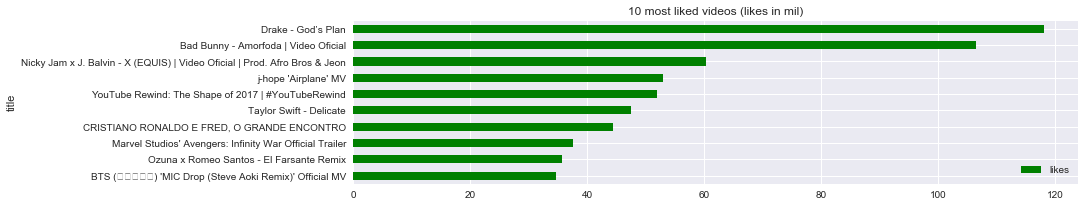

In [123]:

metrics = ['likes','views','comment_count','dislikes']
df_videos_title = df_videos.reset_index().groupby(['country', 'title'])[metrics].sum()
likes = df_videos_title.sort_values('likes',ascending=True)

likes['likes'] = likes.likes / 1000000
likes['comment_count'] = likes.comment_count / 1000000
likes['dislikes'] = likes.dislikes / 1000000

likes.reset_index(inplace=True)
likes.tail(10).plot(kind='barh',x='title',y='likes',title= '10 most liked videos (likes in mil)', color='green', sort_columns=True)
plt.figure(figsize = (16,6))

plt.show()

Views, Likes, Comment Counts, Dislikes per Country

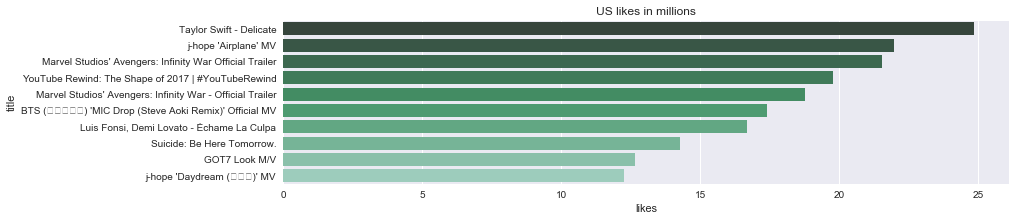

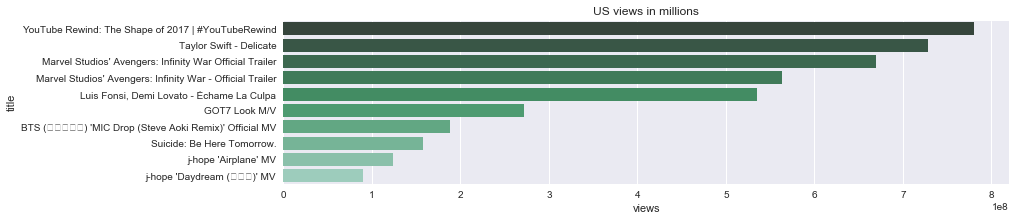

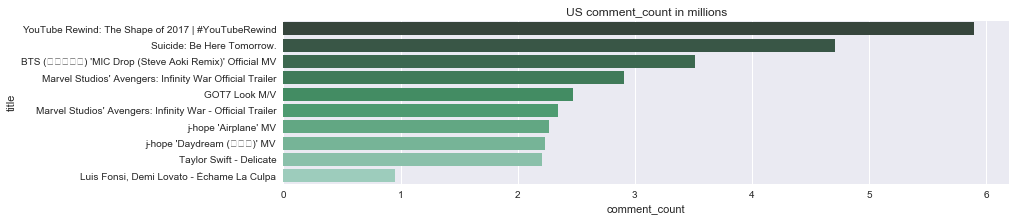

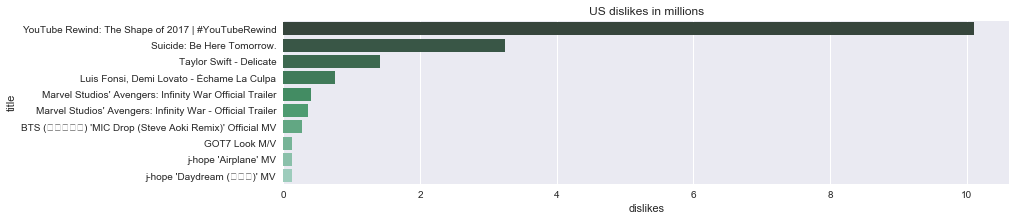

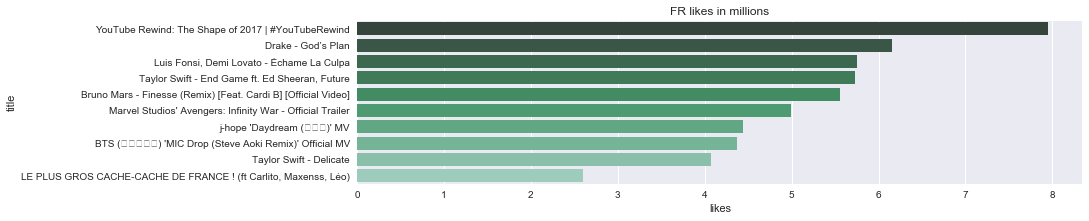

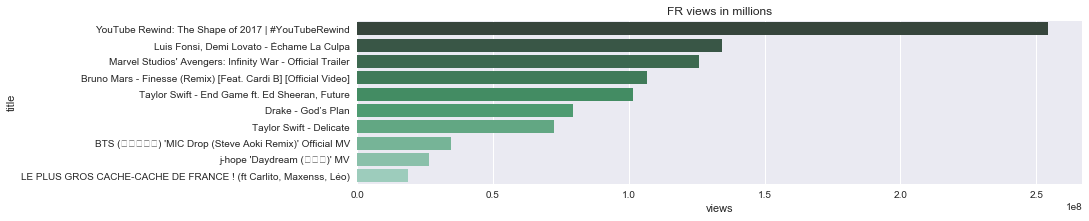

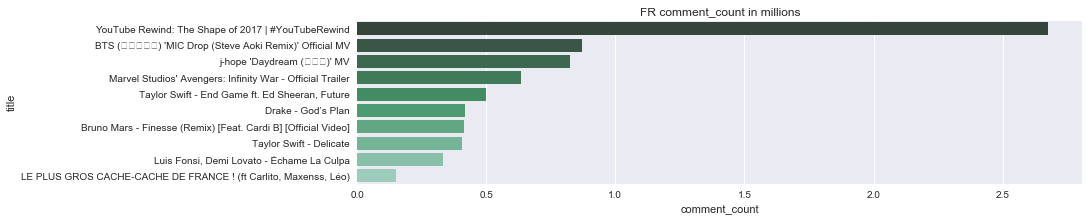

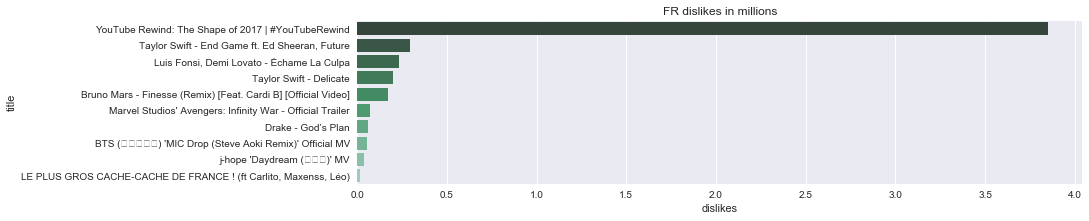

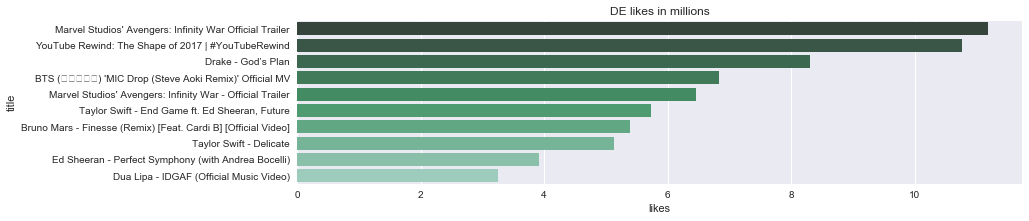

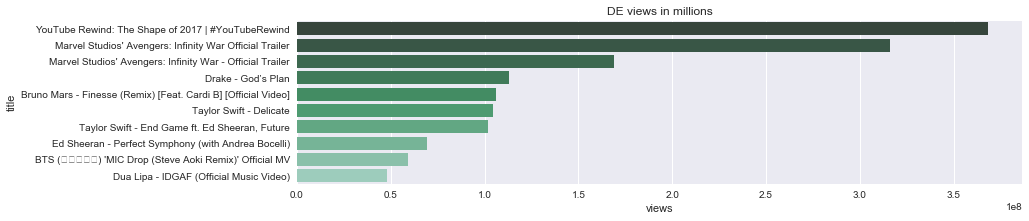

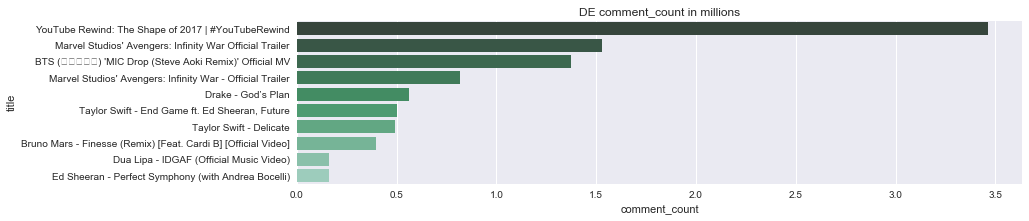

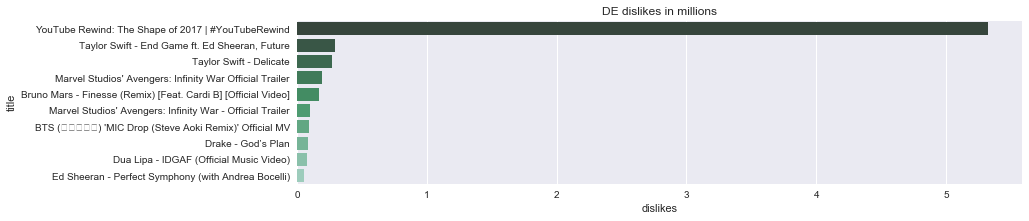

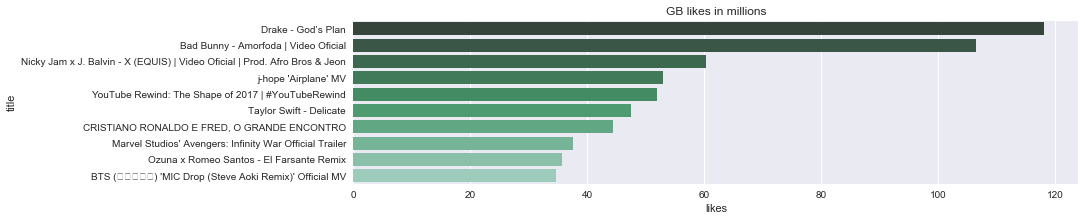

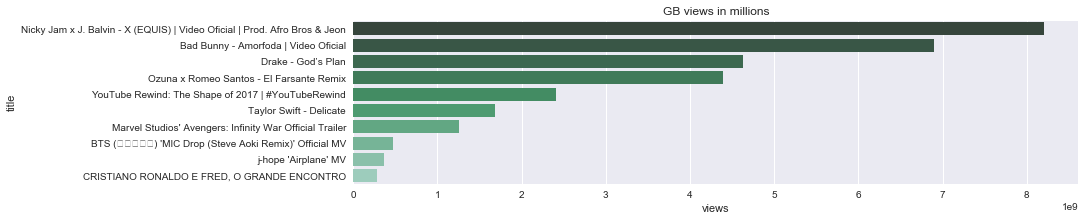

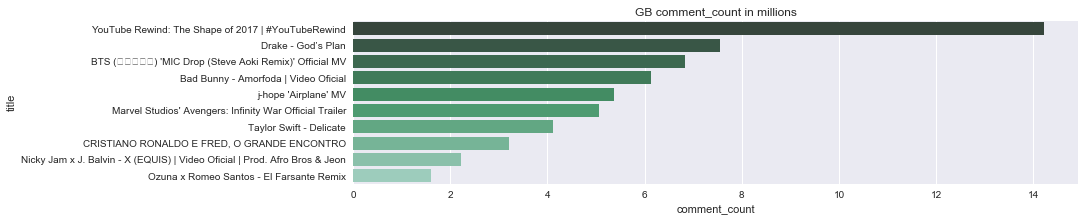

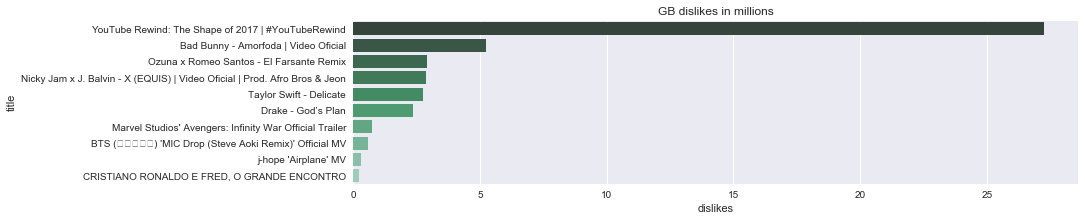

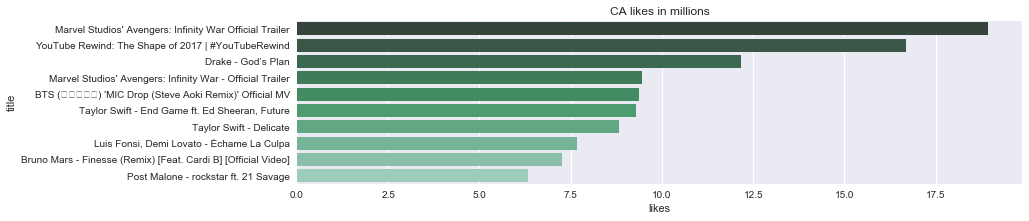

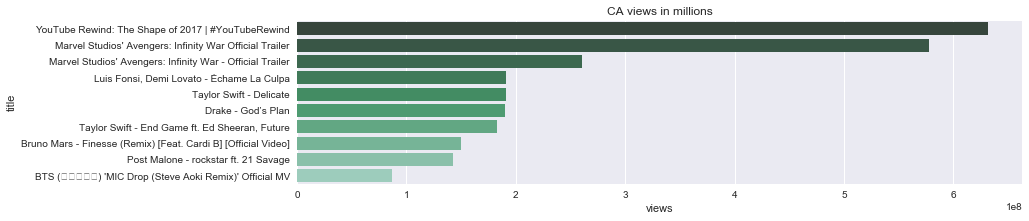

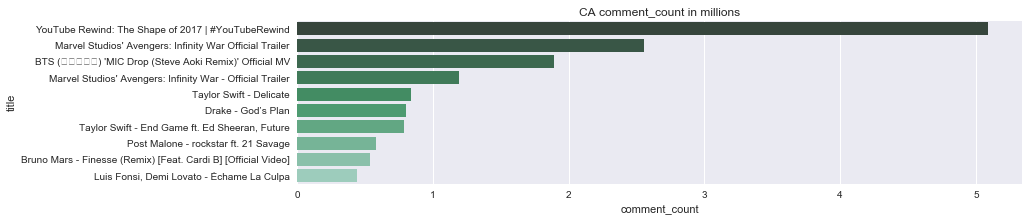

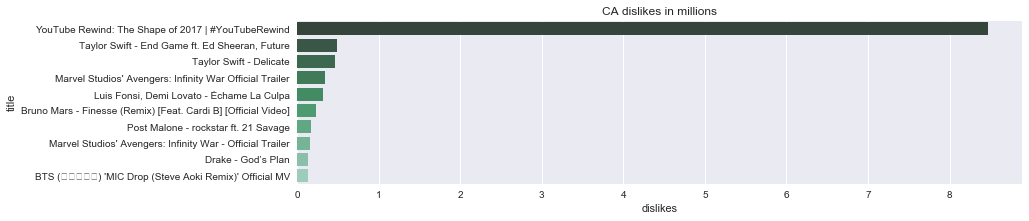

In [124]:
sns.set(rc={'figure.figsize':(13, 3)})
for cntry in likes.country.unique():
    for colm in ['likes', 'views', 'comment_count', 'dislikes']:
        ax = sns.barplot(data=likes.loc[likes.country == cntry, [colm, 'title']].tail(10).\
                     sort_values(colm, ascending=False), y='title',x=colm, 
                        palette="BuGn_d").set_title(cntry + ' ' + colm + ' in millions')
        plt.show()

In [47]:
df_videos['prc_likes'] = df_videos['likes'] / df_videos['views']
df_videos['prc_dislikes'] = df_videos['dislikes'] / df_videos['views']
# df_videos.prc_dislikes = df_videos['dislikes'] / df_videos['views']

In [90]:
#df_videos.columns

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


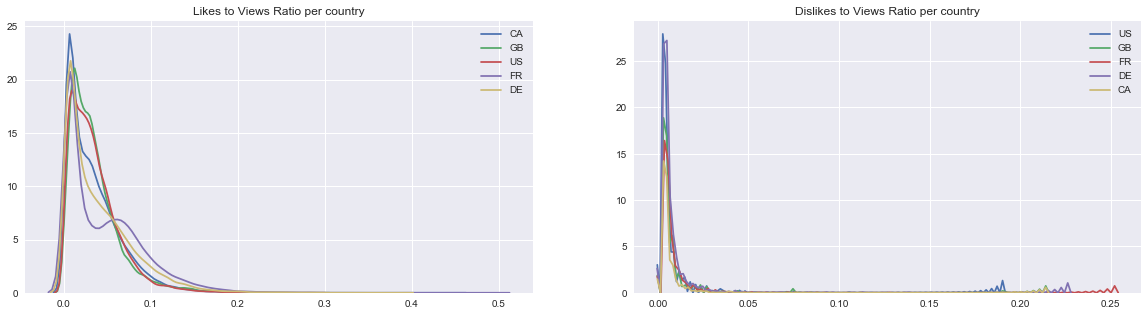

In [125]:
f = plt.figure(figsize=(20,5))

ax = f.add_subplot(121)
sns.kdeplot(df_videos.loc[df_videos.country == 'CA', 'prc_likes'], label='CA')
sns.kdeplot(df_videos.loc[df_videos.country == 'GB', 'prc_likes'], label='GB')
sns.kdeplot(df_videos.loc[df_videos.country == 'US', 'prc_likes'], label='US')
sns.kdeplot(df_videos.loc[df_videos.country == 'FR', 'prc_likes'], label='FR')
sns.kdeplot(df_videos.loc[df_videos.country == 'DE', 'prc_likes'], label='DE')
plt.title('Likes to Views Ratio per country')
plt.legend()


ax2 = f.add_subplot(122)
sns.kdeplot(df_videos.loc[df_videos.country == 'US', 'prc_dislikes'], label='US')
sns.kdeplot(df_videos.loc[df_videos.country == 'GB', 'prc_dislikes'], label='GB')
sns.kdeplot(df_videos.loc[df_videos.country == 'FR', 'prc_dislikes'], label='FR')
sns.kdeplot(df_videos.loc[df_videos.country == 'DE', 'prc_dislikes'], label='DE')
sns.kdeplot(df_videos.loc[df_videos.country == 'CA', 'prc_dislikes'], label='CA')
plt.legend()
plt.title('Dislikes to Views Ratio per country')
plt.show()

In [88]:
#sns.kdeplot(df_videos.loc[df_videos.country == 'US', 'likes'], label='US')
#sns.kdeplot(df_videos.loc[df_videos.country == 'GB', 'likes'], label='GB')
#sns.kdeplot(df_videos.loc[df_videos.country == 'FR', 'likes'], label='FR')
#plt.legend()
#plt.show()

In [89]:
#df_videos.info()

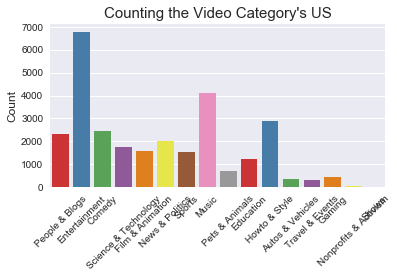

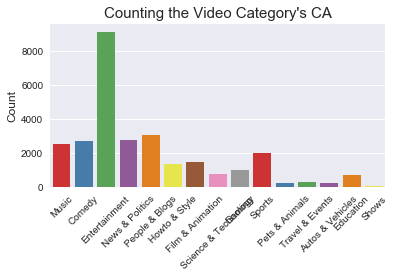

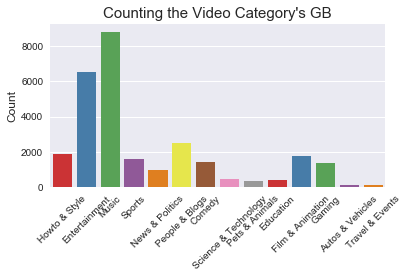

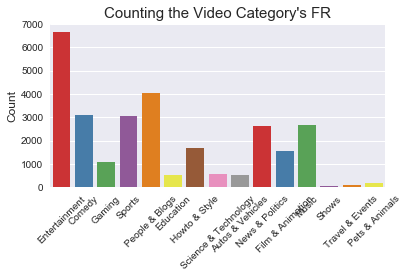

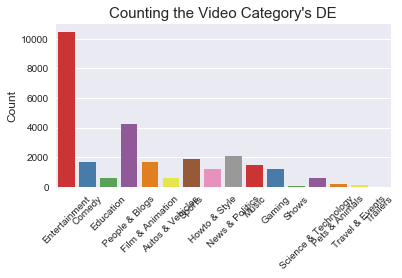

In [117]:
#print(df_videos['snippet.title'].value_counts()[:5])

for i in df_videos.country.unique():
    g = sns.countplot('snippet.title', data=df_videos[df_videos.country==i], palette="Set1")
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title("Counting the Video Category's "+ i, fontsize=15)
    g.set_xlabel("", fontsize=12)
    g.set_ylabel("Count", fontsize=12)
    plt.figure(figsize = (14,6))
    plt.show()

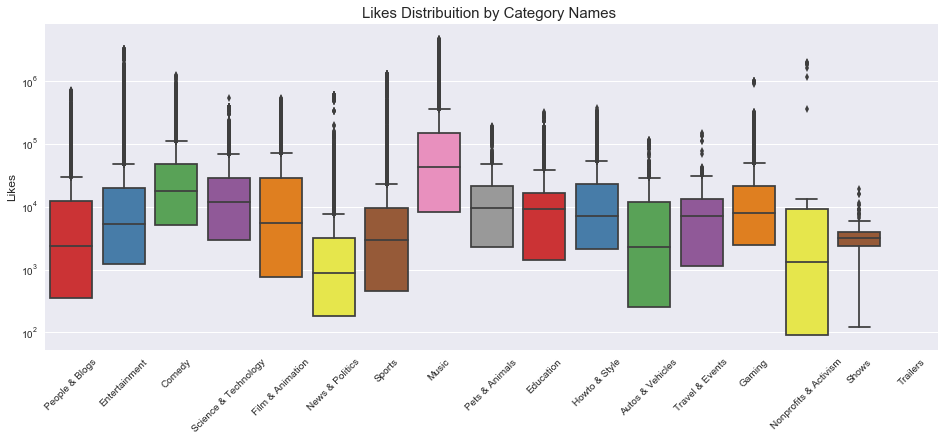

In [120]:
plt.figure(figsize = (16,6))

g = sns.boxplot(x='snippet.title', y='likes', data=df_videos, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Likes Distribuition by Category Names ", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Likes", fontsize=12)
g.set(yscale="log")
plt.show()

In [197]:
df_videos.reset_index()[['country', 'likes']].groupby('country')['likes'].describe() / 1000000

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
CA,0.028454,0.037925,0.118326,0.0,0.002047,0.008651,0.027956,3.014479
DE,0.028348,0.019445,0.086138,0.0,0.000424,0.002324,0.010672,2.811217
FR,0.028376,0.015773,0.073941,0.0,0.000260,0.001590,0.007438,2.656682
GB,0.028367,0.106145,0.293362,0.0,0.004379,0.018012,0.080541,4.737873
US,0.028550,0.049842,0.151624,0.0,0.003306,0.012273,0.036609,3.093544


In [198]:
df_videos.reset_index()[['country', 'views']].groupby('country')['views'].describe() / 1000000

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
CA,0.028454,1.100534,3.334410,0.001000,0.136912,0.347801,0.924822,137.843120
DE,0.028348,0.546813,2.265063,0.000518,0.021698,0.100729,0.387915,113.876217
FR,0.028376,0.374071,1.676319,0.000000,0.012939,0.059199,0.229182,100.911567
GB,0.028367,4.633414,17.359009,0.000851,0.183628,0.691551,2.515851,424.538912
US,0.028550,1.444015,4.384003,0.000549,0.154735,0.440671,1.235440,149.376127


In [199]:
df_videos.reset_index()[['country', 'dislikes']].groupby('country')['dislikes'].describe() / 1000000

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
CA,0.028454,0.001964,0.021562,0.0,0.000093,0.000284,0.000929,1.602383
DE,0.028348,0.001212,0.015807,0.0,0.000023,0.000115,0.000469,1.470386
FR,0.028376,0.000721,0.012434,0.0,0.000014,0.000068,0.000292,1.353661
GB,0.028367,0.006741,0.056883,0.0,0.000150,0.000583,0.002482,1.944971
US,0.028550,0.002771,0.032345,0.0,0.000134,0.000426,0.001344,1.674420


In [200]:
df_videos.reset_index()[['country', 'comment_count']].groupby('country')['comment_count'].describe() / 1000000

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
CA,0.028454,0.004737,0.018244,0.0,0.000386,0.001262,0.003601,0.827755
DE,0.028348,0.002446,0.014318,0.0,0.000066,0.000330,0.001252,0.827755
FR,0.028376,0.001560,0.011239,0.0,0.000046,0.000201,0.000761,0.827755
GB,0.028367,0.010797,0.046146,0.0,0.000508,0.001797,0.006849,1.626501
US,0.028550,0.006139,0.030839,0.0,0.000416,0.001315,0.003930,1.361580


In [201]:
#df_videos.views = df_videos['views'].astype(int)
#a = [type(i) for i in df_videos['views'] ]
#set(a)
#b = [isinstance(i, str) for i in df_videos['views'] ]
#df_videos['view_is_str'] = df_videos['views'].apply(lambda x: isinstance(x, str))
#int(df_videos.loc[df_videos.view_is_str, 'views'].iloc[0])
#df_videos.views = df_videos.views.apply(lambda x: int(x))

In [132]:
plt.figure(figsize = (15,15))

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=150,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_videos['title']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title("WORD CLOUD - DESCRIPTION")
plt.axis('off')
plt.show()

NameError: name 'STOPWORDS' is not defined

In [128]:
def wcloud(data,bgcolor):
    plt.figure(figsize = (20,15))
    cloud = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 50)
    cloud.generate(' '.join(data))
    plt.imshow(cloud)
    plt.axis('off')

In [130]:
df_videos.head(1)

,Country,Row ID,video_id,trending_date,title,channel_title,category_id,publish_time,tags,likes,...,publish_date,publish_month,publish_day,publish_hour,id,snippet.title,country,views,prc_likes,prc_dislikes
0,US,0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01,SHANtell martin,57527,...,2017-11-13,11.0,13.0,17.0,22,People & Blogs,US,748374,0.076869,0.003963


In [131]:
tags_word = df_videos[df_videos['snippet.title']=='News & Politics']['tags'].str.lower().str.cat(sep=' ')

tags_word = re.sub('[^A-Za-z]+', ' ', tags_word)
word_tokens = word_tokenize(tags_word)
filtered_sentence = [w for w in word_tokens if not w in en_stopwords]
without_single_chr = [word for word in filtered_sentence if len(word) > 2]
cleaned_data_title = [word for word in without_single_chr if not word.isdigit()]

wcloud(cleaned_data_title,'white')

NameError: name 'word_tokenize' is not defined

In [202]:
df_videos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142095 entries, 0 to 142094
Data columns (total 27 columns):
Country                   142095 non-null object
Row ID                    142095 non-null int64
video_id                  142095 non-null object
trending_date             142095 non-null datetime64[ns]
title                     142095 non-null object
channel_title             142095 non-null object
category_id               142095 non-null int64
publish_time              142095 non-null datetime64[ns]
tags                      142095 non-null object
likes                     142095 non-null int64
dislikes                  142095 non-null int64
comment_count             142095 non-null float64
thumbnail_link            142095 non-null object
comments_disabled         142095 non-null object
ratings_disabled          142095 non-null object
video_error_or_removed    142095 non-null object
description               142095 non-null object
publish_date              142095 non-null o

In [204]:
df_videos_title.head()

likes  \
country title                                                                         
CA      !! THIS VIDEO IS NOTHING BUT PAIN !! | Getting Over It - Part 7       47058   
        #1 Fortnite World Rank - 2,323 Solo Wins!                             5199    
        #1 Fortnite World Rank - 2,330 Solo Wins!                             5620    
        #1 MOST ANTICIPATED VIDEO (Timber Frame House Raising)                23276   
        #1 WORLD RANKED 1463 SOLO WINS! - FORTNITE BATTLE ROYALE LIVE STREAM  15430   

                                                                               views  \
country title                                                                          
CA      !! THIS VIDEO IS NOTHING BUT PAIN !! | Getting Over It - Part 7       835930   
        #1 Fortnite World Rank - 2,323 Solo Wins!                             212838   
        #1 Fortnite World Rank - 2,330 Solo Wins!                             200764   
        #1 MOST ANTICIPATED VIDEO (Timber Frame House Raising)                311914   
        #1 WORLD RANKED 1463 SOLO WINS! - FORTNITE BATTLE ROYALE LIVE STREAM  541482   

                                                                              comment_count  \
country title                                                                                 
CA      !! THIS VIDEO IS NOTHING BUT PAIN !! | Getting Over It - Part 7       8250.0          
        #1 Fortnite World Rank - 2,323 Solo Wins!                             11.0            
        #1 Fortnite World Rank - 2,330 Solo Wins!                             45.0            
        #1 MOST ANTICIPATED VIDEO (Timber Frame House Raising)                5566.0          
        #1 WORLD RANKED 1463 SOLO WINS! - FORTNITE BATTLE ROYALE LIVE STREAM  40.0            

                                                                              dislikes  
country title                                                                           
CA      !! THIS VIDEO IS NOTHING BUT PAIN !! | Getting Over It - Part 7       1023      
        #1 Fortnite World Rank - 2,323 Solo Wins!                             542       
        #1 Fortnite World Rank - 2,330 Solo Wins!                             537       
        #1 MOST ANTICIPATED VIDEO (Timber Frame House Raising)                488       
        #1 WORLD RANKED 1463 SOLO WINS! - FORTNITE BATTLE ROYALE LIVE STREAM  891

In [205]:
df_videos_title.reset_index()['country'] == 'FR'

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
66569    False
66570    False
66571    False
66572    False
66573    False
66574    False
66575    False
66576    False
66577    False
66578    False
66579    False
66580    False
66581    False
66582    False
66583    False
66584    False
66585    False
66586    False
66587    False
66588    False
66589    False
66590    False
66591    False
66592    False
66593    False
66594    False
66595    False
66596    False
66597    False
66598    False
Name: country, Length: 66599, dtype: bool

In [206]:
df_videos_title['likes']>0

country  title                                                                                               
CA       !! THIS VIDEO IS NOTHING BUT PAIN !! | Getting Over It - Part 7                                         True
         #1 Fortnite World Rank - 2,323 Solo Wins!                                                               True
         #1 Fortnite World Rank - 2,330 Solo Wins!                                                               True
         #1 MOST ANTICIPATED VIDEO (Timber Frame House Raising)                                                  True
         #1 WORLD RANKED 1463 SOLO WINS! - FORTNITE BATTLE ROYALE LIVE STREAM                                    True
         #1 World Ranked - 1,700 Solo Wins -  New Minigun Update                                                 True
         #10 Most Emotional Moments in Cricket History | Cricket Friendship Moments                              True
         #267 DID JESUS EXIST?? Jordan Peterson and Lindsay Shep

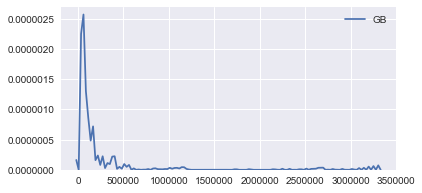

In [207]:
# sns.kdeplot(df_videos.loc[list((df_videos_title.reset_index()['country'] == 'FR') & (df_videos_title.reset_index()['likes']>0)), 'likes'], 
#             label='FR')
sns.kdeplot(df_videos.loc[list(df_videos_title.reset_index()['country'] == 'GB'), 'likes'], label='GB')
# sns.kdeplot(df_videos_title.loc[list(df_videos_title.reset_index()['country'] == 'US'), 'likes'], label='US')
plt.legend()
plt.show()

In [208]:
df_videos_title.shape

(66599, 4)

In [80]:
likes.head()

,country,title,likes,comment_count,dislikes
0,US,RAPID EYE MOVEMENT⎪Official Teaser Trailer,0,6.0,0
1,FR,شاهد ماذا قال رابح ماجر عن خروج محرز ( والله ميزيد يلعب )......,0,333.0,0
2,FR,La dernière Lune de l'année2017,0,46.0,0
3,DE,[ENG] 171129 [EPISODE] BTS (방탄소년단) ‘MIC Drop’ MV Shooting,0,1031.0,0
4,FR,Franck Dubosc - On n'est pas couché 10 mars 2018 #ONPC,0,0.0,0


#### Most liked videos of all countries

#### Most viewd videos of all countries

#### 10 most liked, disliked, viewed videos per country

In [43]:
likes.head()[['country', 'comment_count']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
country          5 non-null object
comment_count    5 non-null float64
dtypes: float64(1), object(1)
memory usage: 160.0+ bytes


In [94]:
likes['likes'] = likes.likes / 1000000
likes['comment_count'] = likes.comment_count / 1000000
likes['dislikes'] = likes.dislikes / 1000000

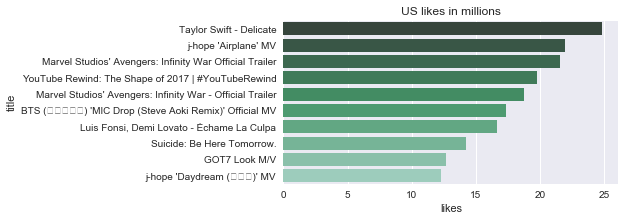

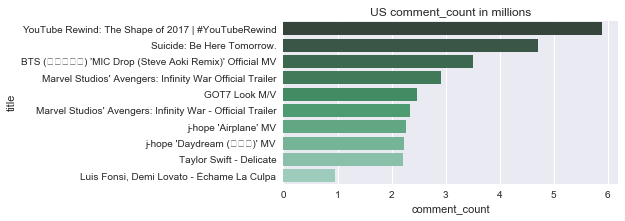

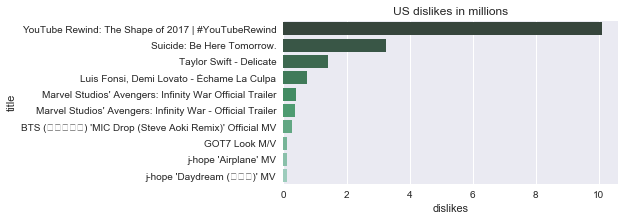

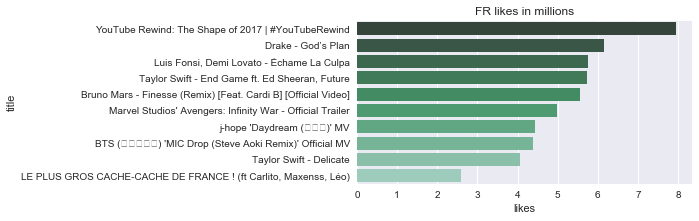

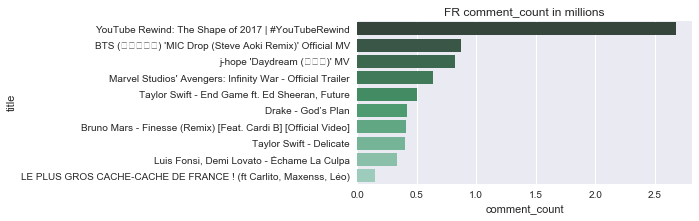

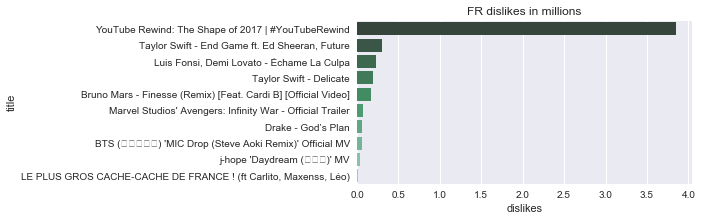

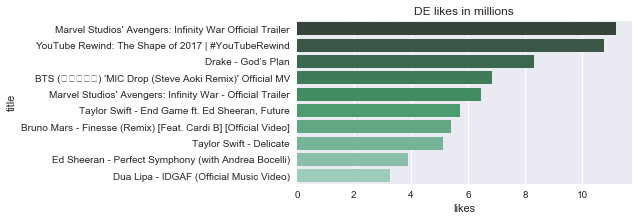

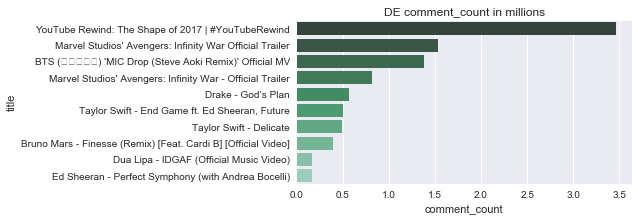

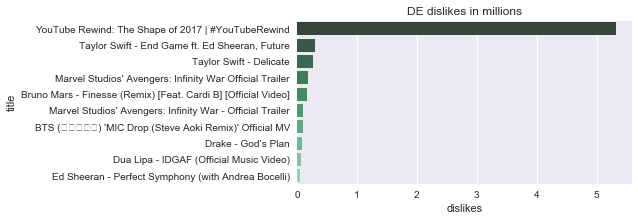

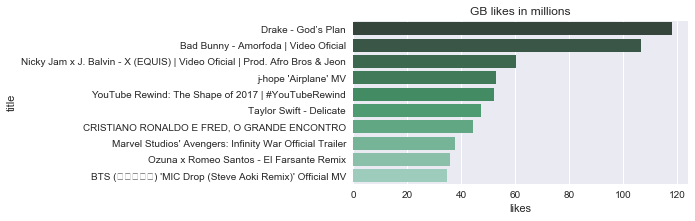

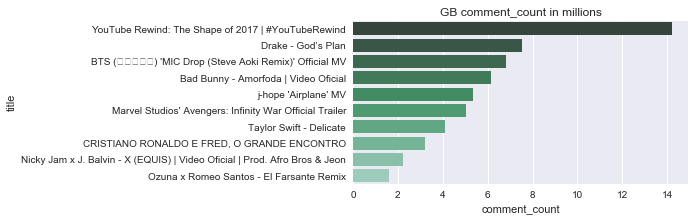

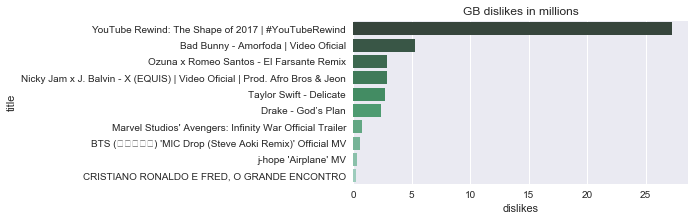

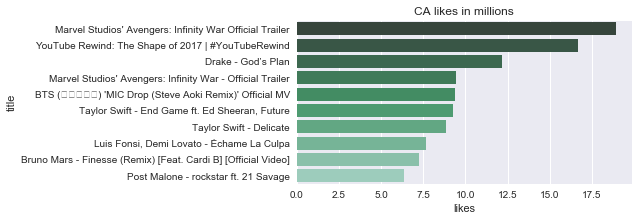

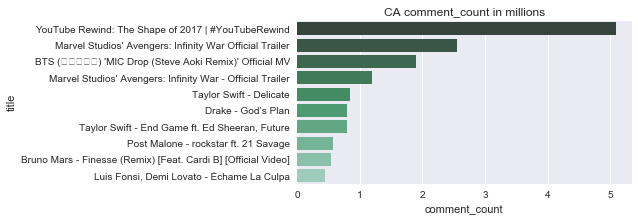

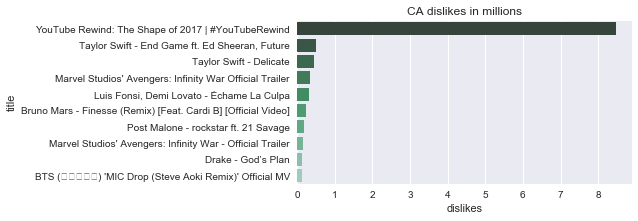

In [115]:
sns.set(rc={'figure.figsize':(6, 3)})
for cntry in likes.country.unique():
    for colm in ['likes', 'comment_count', 'dislikes']:
        ax = sns.barplot(data=likes.loc[likes.country == cntry, [colm, 'title']].tail(10).\
                     sort_values(colm, ascending=False), y='title',x=colm, 
                        palette="BuGn_d").set_title(cntry + ' ' + colm + ' in millions')
        plt.show()

In [101]:
sns.set(rc={'figure.figsize':(6, 3)})
for colm in ['likes', 'comment_count', 'dislikes']:
    for cntry in likes.country.unique():
        ax = sns.barplot(data=likes.loc[likes.country == cntry, [colm, 'title']].tail(10).\
                     sort_values(colm, ascending=False), y='title',x=colm, 
                        palette="BuGn_d").set_title(cntry + ' ' + colm + ' in millions')
        plt.show()

NameError: name 'likes' is not defined

In [102]:
#likes.groupby('country').tail(10)

In [88]:
#g = sns.FacetGrid(melted, col="variable")
#g.map(sns.barplot,'interval','value')

In [89]:
#likes.loc[likes.country == cntry, ['likes', 'title']].tail(10)

In [85]:
#grid = sns.FacetGrid(likes.groupby('country').tail(10)[['title', 'likes', 'country']], col='country')
#g = grid.map(sns.barplot,  'likes', 'title')
# grid.axes[0][0].legend()
# bp.set_titles("{col_name}")
# bp.set_ylabels("Time (s)")
# bp.set_xlabels("Number")


In [86]:
# fig, ax = plt.subplots(nrows=2, ncols=3)
#for cntry in likes.country.unique():
#plt.subplots(nrows=2, ncols=3)
#likes[likes.country == cntry][['likes', 'title']].tail(10).plot(kind='barh',x='title',y='likes', title= '10 most liked videos')
#plt.show()

In [90]:
#likes.tail(10)

### Trend Videos

In [228]:
df_videos_trend = pd.DataFrame(df_videos.reset_index().groupby(['country', 'video_id'])['title'].count())
df_videos_trend.reset_index(inplace=True)
#df_videos_trend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66323 entries, 0 to 66322
Data columns (total 3 columns):
country     66323 non-null object
video_id    66323 non-null object
title       66323 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [231]:
df_videos_trend.head(10)

,country,video_id,title
0,CA,--wOJ2VyKDI,1
1,CA,-0DjA_r32uQ,1
2,CA,-0F7AFzWXik,1
3,CA,-0NhqVYR4UY,1
4,CA,-0QvjiG4sYM,2
5,CA,-0XP8UXesHg,1
6,CA,-0qe75Q5vOg,1
7,CA,-10X8LZxvOE,1
8,CA,-195_1aDUyc,2
9,CA,-2ZDiW0dgIw,1


How long usually a video can trend in different countries?
The greater the number of apperances indicate the long-last the video trend is.

In [236]:
sns.set(rc={'figure.figsize':(6, 3)})
for cntry in df_videos_trend.country.unique():
    for colm in ['title']:
        ax = sns.barplot(data=df_videos_trend.loc[df_videos_trend.country == cntry, [colm]]\
                     sort_values(colm, ascending=False), y='cntry',x=colm, 
                        palette="BuGn_d").set_title(colm)
        plt.show()

ValueError: Could not interpret input 'cntry'

In [222]:
df_videos_trend.reset_index(inplace=True)

In [ ]:
#print(df_videos['snippet.title'].value_counts()[:5])

In [115]:

Nrows = math.ceil(len(df_videos.country) / 2.)

for i in df_videos.country.unique():
    g = sns.countplot('snippet.title', data=df_videos[df_videos.country==i], palette="Set1")
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title("Counting the Video Category's "+ i, fontsize=15)
    g.set_xlabel("", fontsize=12)
    g.set_ylabel("Count", fontsize=12)
    plt.figure(figsize = (14,6))
    plt.subplot(Nrows, 2, i+1)
    plt.show()



TypeError: must be str, not int

## How many likes, dislikes, views and comments get by different countries?

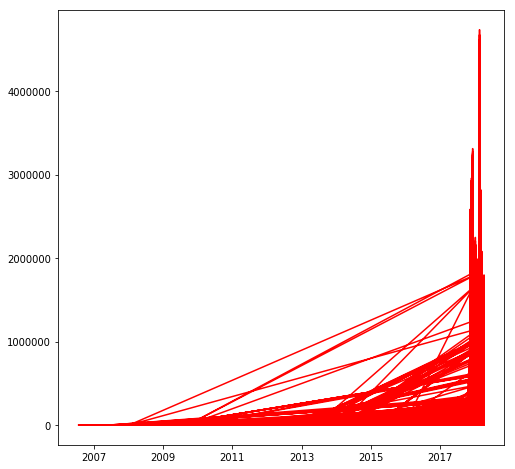

In [81]:
plt.figure(figsize=(8,8))
plt.plot(df_videos["publish_time"],df_videos["likes"],color="red",label="likes")

plt.show()

cat_df_gb = videos_all[videos_all['Country']=='GB']['category'].value_counts().reset_index()

video_level['views_min_dt'] = video_level.views_min_dt.dt.to_period('Q')
tmp = video_level.groupby(['category','views_min_dt']).views_ratio.median()
_ = tmp.unstack().plot(kind='bar')

hour_grp = df_videos.groupby('publish_hour')[metrics].sum()
hour_grp.reset_index(inplace=True)

Analysis : Users like videos from which CATEGORY the most?